In [23]:
!git add '01_데이터셋_구축_코드.ipynb'
!git commit -m "edit) labels path"
!git push origin main

[main 35b8b35] edit) labels path
 1 file changed, 41 insertions(+), 43 deletions(-)
오브젝트 나열하는 중: 5, 완료.
오브젝트 개수 세는 중: 100% (5/5), 완료.
Delta compression using up to 8 threads
오브젝트 압축하는 중: 100% (3/3), 완료.
오브젝트 쓰는 중: 100% (3/3), 580.03 KiB | 12.61 MiB/s, 완료.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/tashapark/cctv_object_detection.git
   d982f9e..35b8b35  main -> main


In [3]:
# 파일 명 변경시.. 걍 업데이트로 하자 
! git add -u 
! git commit -m "Rename notebook files"
! git push origin main

[main 214b166] Rename notebook files
 2 files changed, 283 insertions(+), 101 deletions(-)
오브젝트 나열하는 중: 9, 완료.
오브젝트 개수 세는 중: 100% (9/9), 완료.
Delta compression using up to 8 threads
오브젝트 압축하는 중: 100% (5/5), 완료.
오브젝트 쓰는 중: 100% (5/5), 2.09 KiB | 118.00 KiB/s, 완료.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/tashapark/cctv_object_detection.git
   3d7c133..214b166  main -> main


# 0. 객체탐지(b-box) 모델을 조사
- 조사한 모델이 예상 성능 요구 사항을 충족시킬 수 있는지 확인해주세요. 확인한 내용을 **PPT 1장~3장**으로 정리해서 제출해주세요.
- 모델의 라이센스, 오픈 모델의 성능을 파악해서 왜 해당 모델을 선택했는지 작성이 되어야합니다.
- 업무요청 가이드에서는 yolov5 모델을 baseline모델로 사용하라고 되어있지만, 다른 b-box 모델을 조사했을 때 더 좋은 성능의 모델이 있다면 그 모델로 진행해도 좋습니다.


# 데이터셋 구축
- 아래의 코드 가이드를 참고해서 데이터셋 구축하는 코드를 작성해주세요
- 완료된 데이터셋 구축 코드는 **.ipynb 파일을 다운해서 제출**해주세요.

# 1. Mount google drive
- 코랩을 활용할 경우, 구글 드라이브에 있는 데이터를 사용하기 위해서 마운트 작업이 필요합니다.
- 로컬에서 진행할 경우엔 생략해주세요.
- 로컬에서 진행할 경우엔 conda를 활용하여 가상환경을 세팅해주세요.

# 2. Import Library
- 코드에 사용되는 파이썬 라이브러리를 불러옵니다.

In [16]:
#가상환경 생성 후 인스톨이 늘어남. 
#!pip install opencv-python
#!pip install matplotlib
#!pip install tqdm
#!pip install scikit-learn

In [1]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm       # 작업 진행 속도를 보는데 유용한 라이브러리입니다.
from sklearn.model_selection import train_test_split

In [3]:
#!pip show tqdm

In [2]:
# warning 무시 코드
warnings.filterwarnings(action='ignore')

In [3]:
# 현재 실행 파일 경로 확인
os.getcwd()

'/Users/tasha/Desktop/comento/mywork/notebooks'

# 3. 데이터셋 준비
- 데이콘의 데이터셋은 차종으로 라벨링 되어 있는데, 우리는 차 종류를 객체탐지하는 것이 아닌 "차"를 객체탐지하는 것이 목표입니다.
- 차 종류로 라벨링 된 text파일 데이터를 수정해야합니다.

In [4]:
# 기존에 존재하던 데이터셋 폴더 경로 정의
origin_dir = '/Users/tasha/Desktop/comento/dataset/train'  # ex: '/content/drive/MyDrive/comento/1/dataset/data'

import glob

# 원본 라벨파일(.txt) 불러오기
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

print('라벨파일(.txt) 개수 : ',len(label_txts))

라벨파일(.txt) 개수 :  6481


In [9]:
import os

# COCO 형식 라벨을 저장할 폴더 경로
coco_label_dir = '/Users/tasha/Desktop/comento/dataset/coco_labels'

# 폴더가 존재하지 않으면 생성
if not os.path.exists(coco_label_dir):
    os.makedirs(coco_label_dir)

# COCO 형식으로 변환된 JSON 파일 경로
coco_output_dir = os.path.join(coco_label_dir, 'coco_format_labels.json')

# 이후 라벨 변환 코드를 이어서 작성


# 4. detectron2를 위한 라벨링 데이터 수정
- 모든 데이터의 라벨을 "car"로 변경해야합니다.
- 기존 데이터셋의 Labelme 형태를 yolo format을 따라 라벨링 파일을 변경해야합니다.
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format


### 코드 설계 참고
- yolo형식을 그대로 coco형태로 바꿈

In [18]:
import os
import json
from PIL import Image
from tqdm import tqdm

# 📂 경로 설정
image_dir = "/Users/tasha/Desktop/comento/dataset/train"
label_dir = "/Users/tasha/Desktop/comento/dataset/label_data"  # YOLO 라벨이 저장된 폴더
output_coco_json = "/Users/tasha/Desktop/comento/dataset/coco_labels/coco_format_labels.json"

# 카테고리 설정 (예시)
categories = [{"id": 0, "name": "vehicle"}]  # 원하는 클래스 이름으로 변경 가능

# COCO 데이터 저장할 리스트
coco_data = {"images": [], "annotations": [], "categories": categories}

# 🚀 이미지 파일 가져오기
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

# 🔄 변환 과정 진행
annotation_id = 1  # COCO 형식에서는 각 annotation에도 ID가 필요함

for idx, image_file in tqdm(enumerate(image_files), desc="Processing images", total=len(image_files)):
    image_path = os.path.join(image_dir, image_file)
    
    # 이미지 정보 가져오기
    img = Image.open(image_path)
    width, height = img.size

    # COCO 형식의 이미지 정보 추가
    image_id = idx + 1  # COCO에서 ID는 1부터 시작
    coco_data["images"].append({
        "id": image_id,
        "file_name": image_file,
        "width": width,
        "height": height
    })

    # 해당 이미지의 YOLO 라벨 파일 찾기
    label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
    if not os.path.exists(label_file):
        continue  # 라벨이 없으면 넘어감

    # YOLO 형식 라벨을 COCO 형식으로 변환
    with open(label_file, "r") as f:
        lines = f.readlines()
    
    for line in lines:
        parts = list(map(float, line.strip().split()))
        class_id, x_center, y_center, w, h = parts  # YOLO 형식
        
        # COCO의 bbox 형식 (x_min, y_min, width, height)로 변환
        x_min = (x_center - w / 2) * width
        y_min = (y_center - h / 2) * height
        bbox_width = w * width
        bbox_height = h * height

        # COCO 형식의 annotation 추가
        coco_data["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": int(class_id),  # class_id 그대로 사용
            "bbox": [x_min, y_min, bbox_width, bbox_height],
            "area": bbox_width * bbox_height,
            "iscrowd": 0
        })
        annotation_id += 1

# 📝 COCO JSON 파일 저장
with open(output_coco_json, "w") as f:
    json.dump(coco_data, f, indent=4)

print("✅ COCO 변환 완료! JSON 저장 경로:", output_coco_json)


Processing images: 100%|██████████████████| 6481/6481 [00:03<00:00, 1857.24it/s]


✅ COCO 변환 완료! JSON 저장 경로: /Users/tasha/Desktop/comento/dataset/coco_labels/coco_format_labels.json


# 5. 라벨이 제대로 수정되었는지 확인하기
- 아래 함수를 통해 라벨이 제대로 수정되었는지 시각화해서 확인해주세요.
- 항상 작업을 완료후에는 결과를 확인하면서 이슈가 없는지 파악해야합니다.

🔹 이미지 파일 경로: /Users/tasha/Desktop/comento/dataset/train/syn_00000.png
✅ 이미지 파일이 존재합니다.
🔹 이미지 형식: PNG


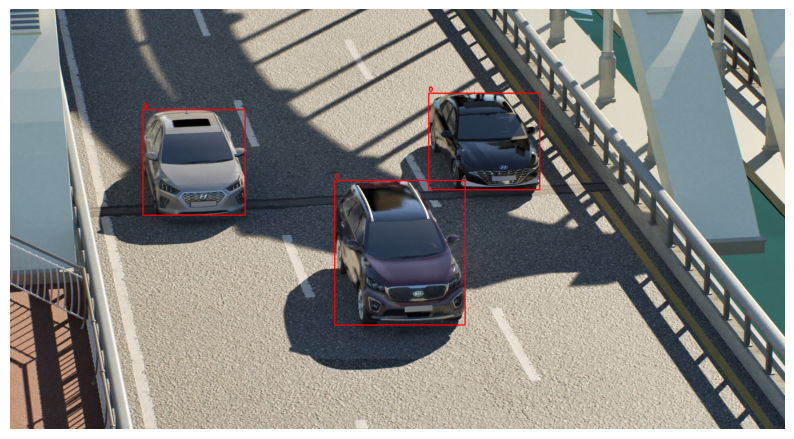

In [19]:
import json
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

# 이미지와 라벨 데이터 경로
image_dir = "/Users/tasha/Desktop/comento/dataset/train"  # 이미지 폴더
coco_label_path = "/Users/tasha/Desktop/comento/dataset/coco_labels/coco_format_labels.json"  # COCO 형식 라벨 파일

# COCO 형식 라벨 파일 로드
with open(coco_label_path, "r") as f:
    coco_data = json.load(f)

# 이미지 ID와 파일명 매핑
image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

# 특정 이미지 선택 (첫 번째 이미지)
image_id = list(image_id_to_filename.keys())[0]  # 첫 번째 이미지 ID
image_file = os.path.join(image_dir, image_id_to_filename[image_id])  # 이미지 경로

# 🔍 이미지 경로 확인
print(f"🔹 이미지 파일 경로: {image_file}")
if not os.path.exists(image_file):
    print("❌ 오류: 해당 경로에 이미지 파일이 존재하지 않습니다!")
else:
    print("✅ 이미지 파일이 존재합니다.")

# 🔍 이미지 파일 형식 확인
try:
    img = Image.open(image_file)
    print(f"🔹 이미지 형식: {img.format}")
    img_width, img_height = img.size
except Exception as e:
    print(f"❌ 오류: 이미지를 불러올 수 없습니다! {e}")

# 바운딩 박스를 그리는 함수
def draw_coco_boxes(image_path, annotations):
    image = cv2.imread(image_path)
    if image is None:
        print("❌ OpenCV로 이미지를 로드할 수 없습니다.")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for ann in annotations:
        x_min, y_min, width, height = ann["bbox"]
        x_max, y_max = x_min + width, y_min + height

        class_id = ann["category_id"]

        # 바운딩 박스 그리기
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (int(x_min), int(y_min) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 해당 이미지의 바운딩 박스 가져오기
annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_id]

# 바운딩 박스 그리기
if os.path.exists(image_file):
    draw_coco_boxes(image_file, annotations)


# 6. train/valid/test set 분리
- 간단한 데이터셋 통계량 확인하고, 데이터셋 비율을 정해줍니다.
  - 차량 데이터 총 개수 확인 (참고 : glob 모듈 사용)
- 학습/검증/테스트셋 분리
  - train_test_split 라이브러리를 활용하여 test_size 인자로 데이터셋 비율을 조절할 수 있습니다. (train_test_split라이브러리는 데이터셋을 분리하는데에 많이 사용되고 있습니다.)
  - trainset : validset : testset  = 6 : 2 : 2

- 이미 욜로로 만들어둔 데이터 셋이 있어서 거기다가 json만 추가함

In [22]:
import os
import json
from sklearn.model_selection import train_test_split

# 📂 COCO 라벨 파일 경로
coco_label_path = "/Users/tasha/Desktop/comento/dataset/coco_labels/coco_format_labels.json"  # COCO 라벨 파일
output_base_dir = "/Users/tasha/Desktop/comento/dataset/coco_datasets"  # 분할된 데이터 저장 경로

# 디렉터리 생성
split_dirs = ["train", "valid", "test"]
for split in split_dirs:
    os.makedirs(os.path.join(output_base_dir, split), exist_ok=True)

# COCO 라벨 파일 로드
with open(coco_label_path, "r") as f:
    coco_data = json.load(f)

# `images`와 `annotations`을 매칭할 딕셔너리 생성
image_id_to_annotations = {img["id"]: [] for img in coco_data["images"]}
for ann in coco_data["annotations"]:
    image_id_to_annotations[ann["image_id"]].append(ann)

# COCO 이미지 리스트 추출
image_files = {img["file_name"]: img for img in coco_data["images"]}

# 1️⃣ COCO 학습/검증/테스트 데이터셋 분할 (6:2:2 비율)
coco_train_images, coco_temp_images = train_test_split(list(image_files.keys()), test_size=0.4, random_state=42)
coco_valid_images, coco_test_images = train_test_split(coco_temp_images, test_size=0.5, random_state=42)

# 📝 COCO JSON 생성 함수
def create_coco_json(image_list, output_json_path):
    new_coco_data = {"images": [], "annotations": [], "categories": coco_data["categories"]}
    
    for img_file in image_list:
        img_data = image_files[img_file]
        new_coco_data["images"].append(img_data)
        new_coco_data["annotations"].extend(image_id_to_annotations[img_data["id"]])

    with open(output_json_path, "w") as f:
        json.dump(new_coco_data, f, indent=4)

# 📁 COCO JSON 저장
create_coco_json(coco_train_images, os.path.join(output_base_dir, "train", "coco_annotations.json"))
create_coco_json(coco_valid_images, os.path.join(output_base_dir, "valid", "coco_annotations.json"))
create_coco_json(coco_test_images, os.path.join(output_base_dir, "test", "coco_annotations.json"))

print("✅ COCO 형식 데이터셋 분할 완료!")


✅ COCO 형식 데이터셋 분할 완료!


# 7. 학습용 train/valid/test 데이터셋 폴더 생성

- 위에서 분리한 train/valid/testset을 옮겨둘 폴더를 생성하고, 파일을 복사해서 옮겨줍니다.
- 아래의 폴더 구조로 만들어주세요.

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

- 데이터를 저장하고자 하는 곳으로 이동 (참고 : shutil.copy 라이브러리 사용)
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
- 구글드라이브의 용량이 부족하다면 데이터를 조금 더 삭제해서 줄여도 괜찮습니다.


- 학습에 사용되는 .yaml 파일을 아래 형식에 맞춰서 만들어줍니다.

```
names:
- car
nc: 1
path: "dataset_folder_root_path"
test: "test_image_dataset_folder_path"
train: "train_image_dataset_folder_path"
val: "validation_image_dataset_folder_path"
```

In [23]:
import yaml

# 저장할 경로 (경로 명시)
yaml_path = "/Users/tasha/Desktop/comento/dataset/coco_datasets/coco.yaml"

data = {
    'names': ["car"],  # 클래스 이름 목록
    'nc': 1,  # 클래스 수
    'path': "/Users/tasha/Desktop/comento/dataset",  # COCO 데이터셋 루트 폴더
    'train': "/Users/tasha/Desktop/comento/dataset/train",  # 학습 데이터셋 이미지 경로
    'val': "/Users/tasha/Desktop/comento/dataset/val",  # 검증 데이터셋 이미지 경로
    'test': "/Users/tasha/Desktop/comento/dataset/test"  # 테스트 데이터셋 이미지 경로
}

# YAML 파일 저장
with open(yaml_path, 'w') as file:
    yaml.dump(data, file)

print(f"YAML 파일 생성 완료! → {yaml_path}")


YAML 파일 생성 완료! → /Users/tasha/Desktop/comento/dataset/coco_datasets/coco.yaml


In [24]:
# 생성한 YAML 파일 읽기
yaml_path = '/Users/tasha/Desktop/comento/dataset/coco_datasets/coco.yaml'

with open(yaml_path, 'r') as f:
    data = yaml.full_load(f)

# 내용 출력
print(data)

{'names': ['car'], 'nc': 1, 'path': '/Users/tasha/Desktop/comento/dataset', 'test': '/Users/tasha/Desktop/comento/dataset/test', 'train': '/Users/tasha/Desktop/comento/dataset/train', 'val': '/Users/tasha/Desktop/comento/dataset/val'}
